In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import time

In [3]:
# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Keras Tuner
import keras_tuner as kt
from kerastuner.tuners import RandomSearch

In [4]:
# Load Dataset
mnist = tf.keras.datasets.mnist

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test= x_train / 255.0, x_test / 255.0

In [6]:
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [7]:
## Define Early Stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [8]:
# Build Model
def build_model1(hp):
    model1 = keras.Sequential()
    model1.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    hp_layer_1 = hp.Int('Layer_1', min_value=1, max_value=1000, step=1)
    hp_layer_2 = hp.Int('Layer_2', min_value=1, max_value=1000, step=1)

    model1.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
    model1.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
    model1.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model1.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                                                            values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model1

In [9]:
tuner1 = RandomSearch(
    build_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='KerasTuner/output',
    project_name='MNIST_KerasTuner'
)

In [10]:
tuner1.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
Layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 1, 'sampling': 'linear'}
Layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [11]:
tuner1.search(x_train, y_train,
             epochs=5,
             validation_data=(x_test, y_test),
             callbacks=[stop_early])

Trial 5 Complete [00h 01m 56s]
val_accuracy: 0.9767000079154968

Best val_accuracy So Far: 0.9796333312988281
Total elapsed time: 00h 09m 54s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner1.results_summary()

Results summary
Results in KerasTuner/output/MNIST_KerasTuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
activation: relu
Layer_1: 767
Layer_2: 601
learning_rate: 0.001
Score: 0.9796333312988281

Trial 0 summary
Hyperparameters:
activation: relu
Layer_1: 697
Layer_2: 895
learning_rate: 0.001
Score: 0.9794333378473917

Trial 3 summary
Hyperparameters:
activation: relu
Layer_1: 752
Layer_2: 455
learning_rate: 0.0001
Score: 0.9777666727701823

Trial 4 summary
Hyperparameters:
activation: relu
Layer_1: 769
Layer_2: 94
learning_rate: 0.0001
Score: 0.9767000079154968

Trial 2 summary
Hyperparameters:
activation: tanh
Layer_1: 697
Layer_2: 986
learning_rate: 0.001
Score: 0.9715666572252909


---

### Select the best Hyperparameters for Model 1

In [13]:
best_hps1 = tuner1.get_best_hyperparameters(num_trials=1)[0]

In [14]:
## Build the model with the best hyperparameters

model1 = tuner1.hypermodel.build(best_hps1)

In [15]:
history1 = model1.fit(x_train, y_train,epochs=5, validation_split=0.2, callbacks=[stop_early])

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1959 - accuracy: 0.9399 - val_loss: 0.1081 - val_accuracy: 0.9653
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0841 - accuracy: 0.9738 - val_loss: 0.0983 - val_accuracy: 0.9706
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0561 - accuracy: 0.9818 - val_loss: 0.1088 - val_accuracy: 0.9711
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0442 - accuracy: 0.9858 - val_loss: 0.1187 - val_accuracy: 0.9697
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0363 - accuracy: 0.9883 - val_loss: 0.1037 - val_accuracy: 0.9738


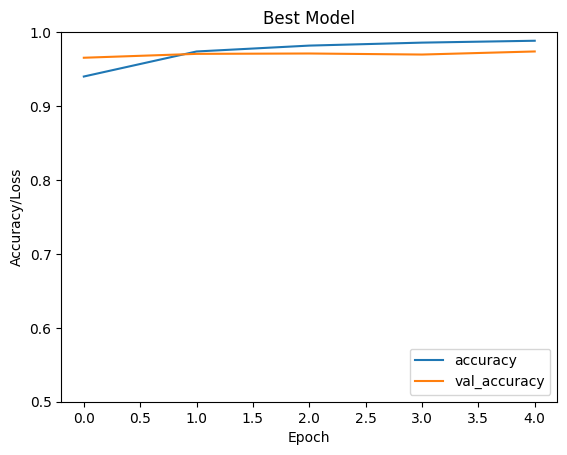

In [16]:
# Plot the learning curves for training and validation accuracy/loss for the best model
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model')
plt.show()

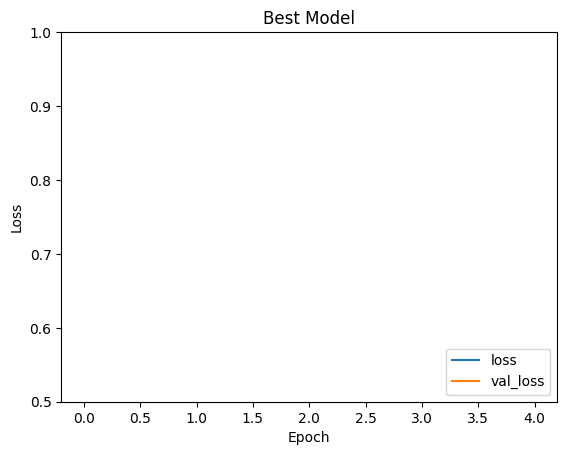

In [17]:
# Plot the loss for the best model
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model')
plt.show()

---

## Model 2

Add for loops to iterate over the hyperparameters

In [18]:
# Build Model
def build_model2(hp):
    model2 = keras.Sequential()
    model2.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    for i in range(hp.Int('layers', 2, 6)):
        model2.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(i), 
                         min_value=1,
                         max_value=1000,
                         step=1),
                         activation=hp_activation)
        )
    
    
    model2.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model2.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                                                            values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model2

In [19]:
tuner2 = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='KerasTuner/output',
    project_name='MNIST_KerasTuner2'
)

In [20]:
tuner2.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [21]:
# Measure the execution time for hyperparameter tuning
start_time = time.time()
tuner2.search(x_train, y_train,
             epochs=5,
             validation_data=(x_test, y_test),
             callbacks=[stop_early])
end_time = time.time()

exec_time2= end_time - start_time
print("Execution Time (Random Search): ", exec_time2, " seconds")

Trial 5 Complete [00h 02m 16s]
val_accuracy: 0.9647000034650167

Best val_accuracy So Far: 0.9739666779836019
Total elapsed time: 00h 11m 16s
INFO:tensorflow:Oracle triggered exit
Execution Time (Random Search):  676.3533582687378  seconds


In [22]:
tuner2.results_summary()

Results summary
Results in KerasTuner/output/MNIST_KerasTuner2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
activation: tanh
layers: 2
units_0: 399
units_1: 644
learning_rate: 0.001
Score: 0.9739666779836019

Trial 4 summary
Hyperparameters:
activation: relu
layers: 2
units_0: 376
units_1: 147
learning_rate: 0.01
units_2: 901
units_3: 421
units_4: 426
units_5: 708
Score: 0.9647000034650167

Trial 3 summary
Hyperparameters:
activation: tanh
layers: 3
units_0: 961
units_1: 173
learning_rate: 0.01
units_2: 595
units_3: 205
units_4: 30
units_5: 964
Score: 0.7476999759674072

Trial 1 summary
Hyperparameters:
activation: tanh
layers: 4
units_0: 158
units_1: 118
learning_rate: 0.001
units_2: 1
units_3: 1
Score: 0.34843332568804425

Trial 2 summary
Hyperparameters:
activation: tanh
layers: 6
units_0: 278
units_1: 188
learning_rate: 0.0001
units_2: 660
units_3: 507
units_4: 1
units_5: 1
Score: 0.21050000190734863


---

In [ ]:
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
## Build the model with the best hyperparameters

model2 = tuner2.hypermodel.build(best_hps2)
history2 = model2.fit(x_train, y_train,epochs=5, validation_split=0.2, callbacks=[stop_early])

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3014 - accuracy: 0.1133 - val_loss: 2.3021 - val_accuracy: 0.1060
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3012 - accuracy: 0.1140 - val_loss: 2.3022 - val_accuracy: 0.1060
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3012 - accuracy: 0.1140 - val_loss: 2.3022 - val_accuracy: 0.1060
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3011 - accuracy: 0.1140 - val_loss: 2.3023 - val_accuracy: 0.1060
Epoch 5/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3012 - accuracy: 0.1140 - val_loss: 2.3021 - val_accuracy: 0.1060


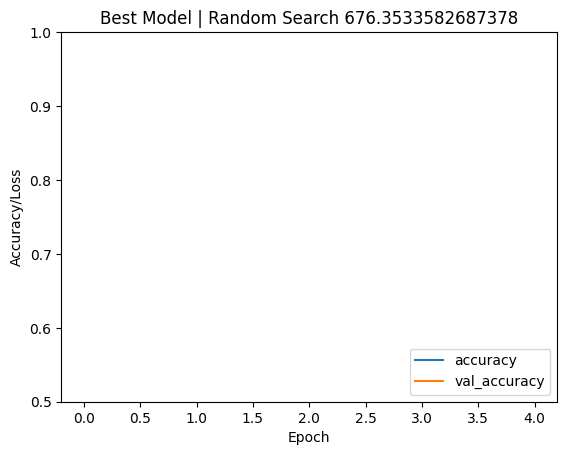

In [23]:
# Plot the learning curves for training and validation accuracy/loss for the best model
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model | Random Search {}'.format(exec_time2))
plt.show()

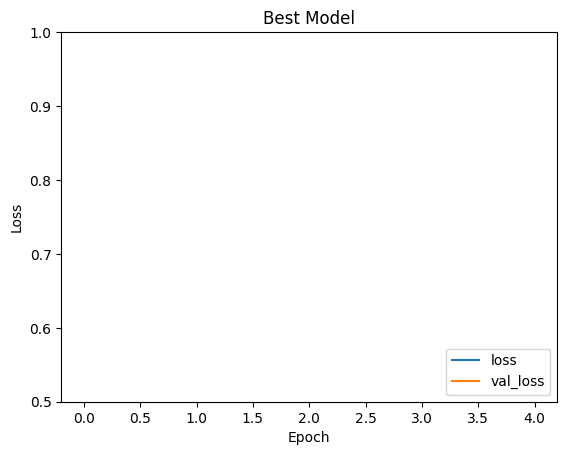

In [24]:
# Plot the loss for the best model
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model')
plt.show()

---

## Model 3

Add for loops to iterate over the hyperparameters

In [25]:
# Build Model
def build_model3(hp):
    model3 = keras.Sequential()
    model3.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    for i in range(hp.Int('layers', 2, 6)):
        model3.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(i), 
                         min_value=1,
                         max_value=1000,
                         step=1),
                         activation=hp_activation)
        )
    
    
    model3.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model3.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                                                            values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model3

In [26]:
tuner3 = kt.Hyperband(
    build_model3,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='KerasTuner/output',
    project_name='MNIST_KerasTuner3'
)


In [27]:
tuner3.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [28]:
# Measure the execution time for hyperparameter tuning
start_time = time.time()
tuner3.search(x_train, y_train,
             epochs=5,
             validation_data=(x_test, y_test),
             callbacks=[stop_early])
end_time = time.time()

exec_time3= end_time - start_time
print("Execution Time (HyperBand): ", exec_time3, " seconds")

Trial 10 Complete [00h 03m 41s]
val_accuracy: 0.9794999957084656

Best val_accuracy So Far: 0.9799000024795532
Total elapsed time: 00h 13m 54s
INFO:tensorflow:Oracle triggered exit
Execution Time (HyperBand):  834.0576043128967  seconds


In [29]:
tuner3.results_summary()

Results summary
Results in KerasTuner/output/MNIST_KerasTuner3
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
activation: relu
layers: 5
units_0: 725
units_1: 33
learning_rate: 0.001
units_2: 492
units_3: 556
units_4: 935
units_5: 850
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.9799000024795532

Trial 0009 summary
Hyperparameters:
activation: relu
layers: 2
units_0: 552
units_1: 821
learning_rate: 0.001
units_2: 565
units_3: 197
units_4: 410
units_5: 27
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9794999957084656

Trial 0006 summary
Hyperparameters:
activation: tanh
layers: 2
units_0: 145
units_1: 760
learning_rate: 0.001
units_2: 902
units_3: 907
units_4: 411
units_5: 310
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0003
Score: 0.9742000102996826

Trial 0004 summary
Hyperparameters:
activatio

---

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.0065 - accuracy: 0.2135 - val_loss: 1.8623 - val_accuracy: 0.2418
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8151 - accuracy: 0.2528 - val_loss: 1.7610 - val_accuracy: 0.2592
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7456 - accuracy: 0.2679 - val_loss: 1.7123 - val_accuracy: 0.2697
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7085 - accuracy: 0.2755 - val_loss: 1.6827 - val_accuracy: 0.2678
Epoch 5/5
1500/1500 [==============================] - 7s 5ms/step - loss: 1.6831 - accuracy: 0.2753 - val_loss: 1.6591 - val_accuracy: 0.2882


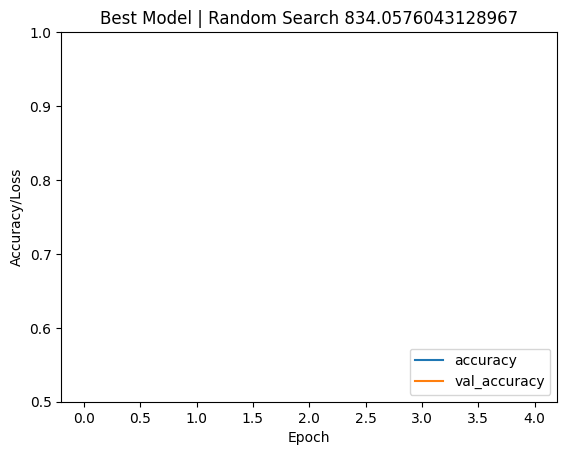

In [30]:
best_hps3 = tuner2.get_best_hyperparameters(num_trials=1)[0]
## Build the model with the best hyperparameters

model3 = tuner3.hypermodel.build(best_hps1)
history3 = model3.fit(x_train, y_train,epochs=5, validation_split=0.2, callbacks=[stop_early])

# Plot the learning curves for training and validation accuracy/loss for the best model
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model | Random Search {}'.format(exec_time3))
plt.show()

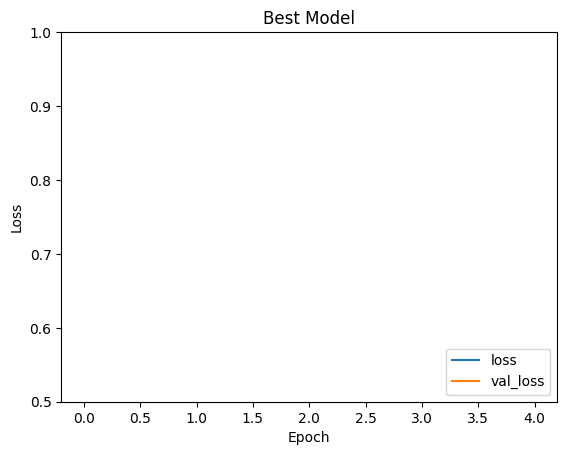

In [31]:
# Plot the loss for the best model
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model')
plt.show()

---

## Model 4

In [ ]:
# Build Model
def build_model4(hp):
    model4 = tf.keras.Sequential([
        keras.layers.Conv2D(
            filters = hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
            kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),
            activation = 'relu',
            input_shape = (28,28,1)
        ),
        keras.layers.Conv2D(
            filters = hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
            activation = 'relu'
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units = hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation = 'relu'
        ),
        keras.layers.Dense(10, activation='softmax')
    ])

    model4.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model4

In [ ]:
tuner4 = kt.Hyperband(
    build_model4,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='KerasTuner/output',
    project_name='MNIST_KerasTuner4'
)

INFO:tensorflow:Reloading Tuner from KerasTuner/output/MNIST_KerasTuner4/tuner0.json


In [ ]:
tuner4.search_space_summary()

Search space summary
Default search space size: 6
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}


In [ ]:
# Measure the execution time for hyperparameter tuning
start_time = time.time()
tuner4.search(x_train, y_train,
             epochs=5,
             validation_data=(x_test, y_test),
             callbacks=[stop_early])

end_time = time.time()

exec_time4= end_time - start_time
print("Execution Time (Hyperband): ", exec_time4, " seconds")

INFO:tensorflow:Oracle triggered exit
Execution Time (Hyperband):  0.001871347427368164  seconds


In [ ]:
tuner4.results_summary()

Results summary
Results in KerasTuner/output/MNIST_KerasTuner4
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0006 summary
Hyperparameters:
activation: tanh
learning_rate: 0.001
filters: 64
kernel_size: 3
dense_units: 128
layers: 3
conv_1_filter: 128
conv_1_kernel: 3
conv_2_filter: 64
conv_2_kernel: 5
dense_1_units: 64
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9896000027656555

Trial 0005 summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
filters: 64
kernel_size: 3
dense_units: 128
layers: 4
conv_1_filter: 48
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 3
dense_1_units: 128
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9886000156402588

Trial 0007 summary
Hyperparameters:
activation: tanh
learning_rate: 0.0001
filters: 32
kernel_size: 5
dense_units: 64
layers: 2
conv_1_filter: 32
conv_1_kernel: 5
conv_2_filter: 48
conv_2_kernel: 3
dense_1_units: 112
tuner/epochs: 5
t

In [ ]:
best_hps4 = tuner4.get_best_hyperparameters(num_trials=1)[0]
## Build the model with the best hyperparameters

model4 = tuner4.hypermodel.build(best_hps4)
history4 = model4.fit(x_train, y_train,epochs=5, validation_split=0.2, callbacks=[stop_early])

Epoch 1/5
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1124 - accuracy: 0.9656 - val_loss: 0.0560 - val_accuracy: 0.9837
Epoch 2/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0385 - accuracy: 0.9879 - val_loss: 0.0428 - val_accuracy: 0.9863
Epoch 3/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0240 - accuracy: 0.9924 - val_loss: 0.0463 - val_accuracy: 0.9874
Epoch 4/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.0667 - val_accuracy: 0.9847
Epoch 5/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.0585 - val_accuracy: 0.9871


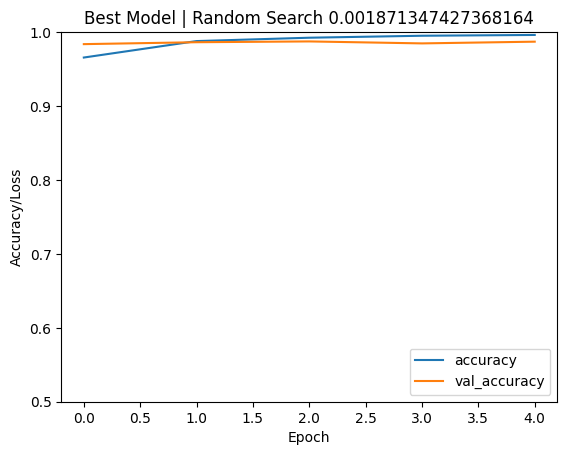

In [ ]:
# Plot the learning curves for training and validation accuracy/loss for the best model
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model | Random Search {}'.format(exec_time4))
plt.show()

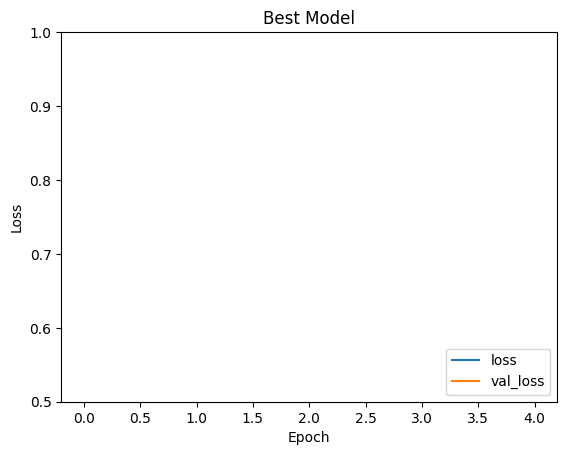

In [ ]:
# Plot the loss for the best model
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model')
plt.show()

----

In [ ]:
# Build Model
def build_model5(hp):
    model5 = tf.keras.Sequential()
    
    # Input layer
    model5.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    
    # Add Conv2D layers iteratively
    for i in range(hp.Int('num_layers', 2, 10, step=2)):
        model5.add(keras.layers.Conv2D(
            filters = hp.Int(f'conv_{i+1}_filter', min_value=32, max_value=128, step=16),
            kernel_size = hp.Choice(f'conv_{i+1}_kernel', values = [3,5]),
            activation = 'relu'
        ))
    
    model5.add(keras.layers.Flatten())
    model5.add(keras.layers.Dense(
        units = hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation = 'relu'
    ))
    model5.add(keras.layers.Dense(10, activation='softmax'))

    model5.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model5

tuner5 = kt.Hyperband(
    build_model5,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='KerasTuner/output',
    project_name='MNIST_KerasTuner5'
)

tuner5.search_space_summary()
tuner5.search(x_train, y_train,
             epochs=5,
             validation_data=(x_test, y_test),
             callbacks=[stop_early])


Trial 4 Complete [00h 01m 12s]
val_accuracy: 0.11349999904632568

Best val_accuracy So Far: 0.986299991607666
Total elapsed time: 00h 03m 40s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
6                 |6                 |num_layers
32                |112               |conv_1_filter
5                 |3                 |conv_1_kernel
112               |64                |conv_2_filter
5                 |3                 |conv_2_kernel
96                |80                |dense_1_units
0.01              |0.001             |learning_rate
80                |32                |conv_3_filter
5                 |3                 |conv_3_kernel
96                |32                |conv_4_filter
3                 |3                 |conv_4_kernel
64                |32                |conv_5_filter
5                 |3                 |conv_5_kernel
80                |32                |conv_6_filter
5                 |3                 |conv_6_kernel
3